# Natural Language Exploration

In [29]:
!pip install kagglehub[pandas-datasets] --quiet

In [30]:
!pip install transformers evaluate accelerate --quiet

In [31]:
!pip install tensorflow[and-cuda] --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-nvrtc-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-runtime-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-runtime-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cudnn-cu12==9.1.0.70; platform_system 

In [32]:
# Data Related
import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder


# NLP and DL
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import mixed_precision
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Embedding,
                                     LSTM,
                                     Bidirectional,
                                     Dense,
                                     GlobalMaxPooling1D,
                                     Dropout)
# Misc
import sys

In [33]:
print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices('GPU')))
# Enable Tensor Core acceleration
mixed_precision.set_global_policy("mixed_float16")

Num GPUs Available: 1


## Version Check

In [34]:
print('Python: {}'.format(sys.version))
print('Pandas: {}'.format(pd.__version__))
print('NumPy: {}'.format(np.__version__))
print('Tensorflow: {}'.format(tf.__version__))

Python: 3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0]
Pandas: 2.2.2
NumPy: 1.26.4
Tensorflow: 2.18.0


In [35]:
file_path = "dataset-tickets-multi-lang-4-20k.csv"

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "tobiasbueck/multilingual-customer-support-tickets",
  file_path,
)

<ipython-input-35-3398c303bdef>:4: DeprecationWarning: load_dataset is deprecated and will be removed in future version.
  df = kagglehub.load_dataset(


## Data Cleaning

### Filtering by English and Dropping Miscellaneous Columns

In [36]:
# Filtering by English
df = df[df['language'] == 'en']

# Defining Misc Tag Columns
misc_metadata = ['tag_2','tag_3','tag_4', 'tag_5', 'tag_6', 'tag_7', 'tag_8']

# Dropping those tags columns
df = df.drop(misc_metadata, axis=1)

df.head()

,subject,body,answer,type,queue,priority,language,tag_1
1,Customer Support Inquiry,Seeking information on digital strategies that...,We offer a variety of digital strategies and s...,Request,Customer Service,medium,en,Feedback
2,Data Analytics for Investment,I am contacting you to request information on ...,I am here to assist you with data analytics to...,Request,Customer Service,medium,en,Technical
4,Security,"Dear Customer Support, I am reaching out to in...","Dear [name], we take the security of medical d...",Request,Customer Service,medium,en,Security
5,Concerns About Securing Medical Data on 2-in-1...,Inquiring about best practices for securing me...,Thank you for your concern regarding securing ...,Request,Technical Support,medium,en,Security
7,Problem with Integration,"The integration stopped working unexpectedly, ...",I will look into the problem and call you at <...,Problem,IT Support,high,en,Technical


In [37]:
# Checking null entries
df.isnull().sum()

,0
subject,1032
body,1
answer,3
type,0
queue,0
priority,0
language,0
tag_1,0


### Imputing Null Subject Lines and Combining Request Data

In [38]:
# Imputing Null Subject Lines
df['subject'].fillna('[No Subject]', inplace=True)

print("Null Subject Values:", df['subject'].isnull().sum())

Null Subject Values: 0


<ipython-input-38-9828db89b150>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['subject'].fillna('[No Subject]', inplace=True)


In [39]:
# Combining subject and body data into one column
df["combined_request"] = df.apply(
    lambda row: f"Subject: {row['subject']} Body: {row['body']}", axis=1
).fillna('')

df["combined_request"].head()

,combined_request
1,Subject: Customer Support Inquiry Body: Seekin...
2,Subject: Data Analytics for Investment Body: I...
4,"Subject: Security Body: Dear Customer Support,..."
5,Subject: Concerns About Securing Medical Data ...
7,Subject: Problem with Integration Body: The in...


## Feature Engineering

In [40]:
df

,subject,body,answer,type,queue,priority,language,tag_1,combined_request
1,Customer Support Inquiry,Seeking information on digital strategies that...,We offer a variety of digital strategies and s...,Request,Customer Service,medium,en,Feedback,Subject: Customer Support Inquiry Body: Seekin...
2,Data Analytics for Investment,I am contacting you to request information on ...,I am here to assist you with data analytics to...,Request,Customer Service,medium,en,Technical,Subject: Data Analytics for Investment Body: I...
4,Security,"Dear Customer Support, I am reaching out to in...","Dear [name], we take the security of medical d...",Request,Customer Service,medium,en,Security,"Subject: Security Body: Dear Customer Support,..."
5,Concerns About Securing Medical Data on 2-in-1...,Inquiring about best practices for securing me...,Thank you for your concern regarding securing ...,Request,Technical Support,medium,en,Security,Subject: Concerns About Securing Medical Data ...
7,Problem with Integration,"The integration stopped working unexpectedly, ...",I will look into the problem and call you at <...,Problem,IT Support,high,en,Technical,Subject: Problem with Integration Body: The in...
...,...,...,...,...,...,...,...,...,...
19992,Guidelines for Securing Medical Data in OBS St...,Seeking details on securing medical data using...,Offering general security guidelines for OBS S...,Request,Technical Support,high,en,Security,Subject: Guidelines for Securing Medical Data ...
19993,[No Subject],Can you provide information on digital strateg...,I would be happy to discuss digital strategies...,Request,Billing and Payments,medium,en,Feedback,Subject: [No Subject] Body: Can you provide in...
19994,Support for Marketing Enhancements,Request for assistance in improving digital ma...,Ready to help with your marketing support need...,Change,Technical Support,high,en,Feedback,Subject: Support for Marketing Enhancements Bo...
19995,Assistance Needed for IFTTT Docker Integration,I am facing integration problems with IFTTT Do...,I would be happy to assist with the IFTTT Dock...,Problem,Technical Support,low,en,Integration,Subject: Assistance Needed for IFTTT Docker In...


In [41]:
# Limiting data for our text classifier - priority = target
model_data = df[["combined_request","type", "tag_1","priority"]]

model_data.head()

,combined_request,type,tag_1,priority
1,Subject: Customer Support Inquiry Body: Seekin...,Request,Feedback,medium
2,Subject: Data Analytics for Investment Body: I...,Request,Technical,medium
4,"Subject: Security Body: Dear Customer Support,...",Request,Security,medium
5,Subject: Concerns About Securing Medical Data ...,Request,Security,medium
7,Subject: Problem with Integration Body: The in...,Problem,Technical,high


### **Optional**: Approach to using tags as an input feature

In [42]:
# Find the top 3 most frequent tags
top_tags = model_data['tag_1'].value_counts().nlargest(3).index

# Replace less frequent values with "Other"
model_data['tag_1'] = model_data['tag_1'].apply(lambda x: x if x in top_tags else 'Other')

print(model_data['tag_1'].value_counts())

tag_1
Other        5580
Technical    3057
Security     2033
Bug          1253
Name: count, dtype: int64


<ipython-input-42-f77e8b653f85>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data['tag_1'] = model_data['tag_1'].apply(lambda x: x if x in top_tags else 'Other')


### Label Encoding

In [60]:
# Label encoding for 'priority'
priority_le = LabelEncoder()
labels = priority_le.fit_transform(model_data['priority'])
print("Priority Classes:", priority_le.classes_)

# Label encoding for 'type'
type_le = LabelEncoder()
feature_inputs = type_le.fit_transform(model_data['type'])
print("Type Classes:", type_le.classes_)

Priority Classes: ['high' 'low' 'medium']
Type Classes: ['Change' 'Incident' 'Problem' 'Request']


### Priority Mapping

0 = high
1 = low
2 = medium

In [74]:
for i, encoded_value in enumerate(labels[:10]):
    category = priority_le.classes_[encoded_value]
    print(f"Encoded priority value {encoded_value} maps to {category}")

Encoded priority value 2 maps to medium
Encoded priority value 2 maps to medium
Encoded priority value 2 maps to medium
Encoded priority value 2 maps to medium
Encoded priority value 0 maps to high
Encoded priority value 0 maps to high
Encoded priority value 0 maps to high
Encoded priority value 2 maps to medium
Encoded priority value 1 maps to low
Encoded priority value 0 maps to high


### Type Mapping
0 = Change
1 = Incident
2 = Problem
3 = Request

In [73]:
for i, encoded_value in enumerate(labels[:10]):
    category = type_le.classes_[encoded_value]
    print(f"Encoded type value {encoded_value} maps to {category}")

Encoded type value 2 maps to Problem
Encoded type value 2 maps to Problem
Encoded type value 2 maps to Problem
Encoded type value 2 maps to Problem
Encoded type value 0 maps to Change
Encoded type value 0 maps to Change
Encoded type value 0 maps to Change
Encoded type value 2 maps to Problem
Encoded type value 1 maps to Incident
Encoded type value 0 maps to Change


### Text Preprocessing

In [45]:
# TODO: Get count of all unique words
# Vocabulary Size (we'll change later)
max_words = 10000

# Max token length per text (We'll change later)
max_length = 512 # TODO: Run distribution of word count for "body" column

# Instantiating and fitting tokenizer
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(model_data['combined_request'])

# Convert text into sequences of integers
sequences = tokenizer.texts_to_sequences(model_data['combined_request'])

# Padding sequences to ensure uniform input length
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post',
                                 truncating='post')

# Reshaping and combining input features
feature_inputs = feature_inputs.reshape(-1,1)
features_combined = np.concatenate([padded_sequences,feature_inputs], axis=1)

# Convert labels to a NumPy array
labels = np.array(labels)

### Save Tokenizer

In [46]:
import pickle
with open("tokenizer.pkl", "wb") as handle:
    pickle.dump(tokenizer, handle)

### Splitting Data

In [47]:
x_train,x_test,y_train,y_test = train_test_split(
    features_combined,labels,test_size=0.2,random_state=42,shuffle=True,
    stratify=labels)

## Modeling (LSTM)

In [48]:
# Model Parameters
embedding_dim = 128
lstm_units = 128  # Increase LSTM units for longer text sequences
num_classes = 3

# Define the model
model = Sequential([
    Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_length),
    Bidirectional(LSTM(lstm_units, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(LSTM(lstm_units // 2, return_sequences=True)),
    GlobalMaxPooling1D(),  # Pooling over the entire sequence
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')  # Multi-class output with 'softmax'
])

# Compile the model for multi-class classification
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=[
                tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')]
                )

# Model Summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_1               │ ?                           │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### Model Training

In [75]:
'''
Monitors the training loss of the model and terminates the training process
if the loss doesn't improve for 5 consecutive epochs.
'''
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                           patience=5,
                                                           restore_best_weights=True)

"""
Saves the best model (best_model.h5) in workign directory.
Ensures the model is only saved if the monitored metric (`val_loss`) improves.
Since we want to minimize the validation loss, we set this to `min`.
"""
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    'best_model.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

# Small Training session, we'll adjust epochs later
history = model.fit(
    x_train, y_train,
    epochs=30,
    batch_size=32,
    validation_data=(x_test, y_test),
    callbacks=[early_stopping_callback, checkpoint_callback]
)


Epoch 1/30
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.6228 - loss: 0.8173
Epoch 1: val_loss improved from inf to 1.00454, saving model to best_model.h5


299/299 ━━━━━━━━━━━━━━━━━━━━ 23s 75ms/step - accuracy: 0.6227 - loss: 0.8173 - val_accuracy: 0.5220 - val_loss: 1.0045
Epoch 2/30
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.6840 - loss: 0.7171
Epoch 2: val_loss did not improve from 1.00454
299/299 ━━━━━━━━━━━━━━━━━━━━ 39s 70ms/step - accuracy: 0.6840 - loss: 0.7171 - val_accuracy: 0.5229 - val_loss: 1.0762
Epoch 3/30
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.7196 - loss: 0.6534
Epoch 3: val_loss did not improve from 1.00454
299/299 ━━━━━━━━━━━━━━━━━━━━ 41s 71ms/step - accuracy: 0.7196 - loss: 0.6534 - val_accuracy: 0.5296 - val_loss: 1.1112
Epoch 4/30
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.7745 - loss: 0.5577
Epoch 4: val_loss did not improve from 1.00454
299/299 ━━━━━━━━━━━━━━━━━━━━ 40s 68ms/step - accuracy: 0.7745 - loss: 0.5577 - val_accuracy: 0.5396 - val_loss: 1.2288
Epoch 5/30
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8089 - loss: 0.4605
Epoch 5: val_loss did not improve f

### Model Visualization

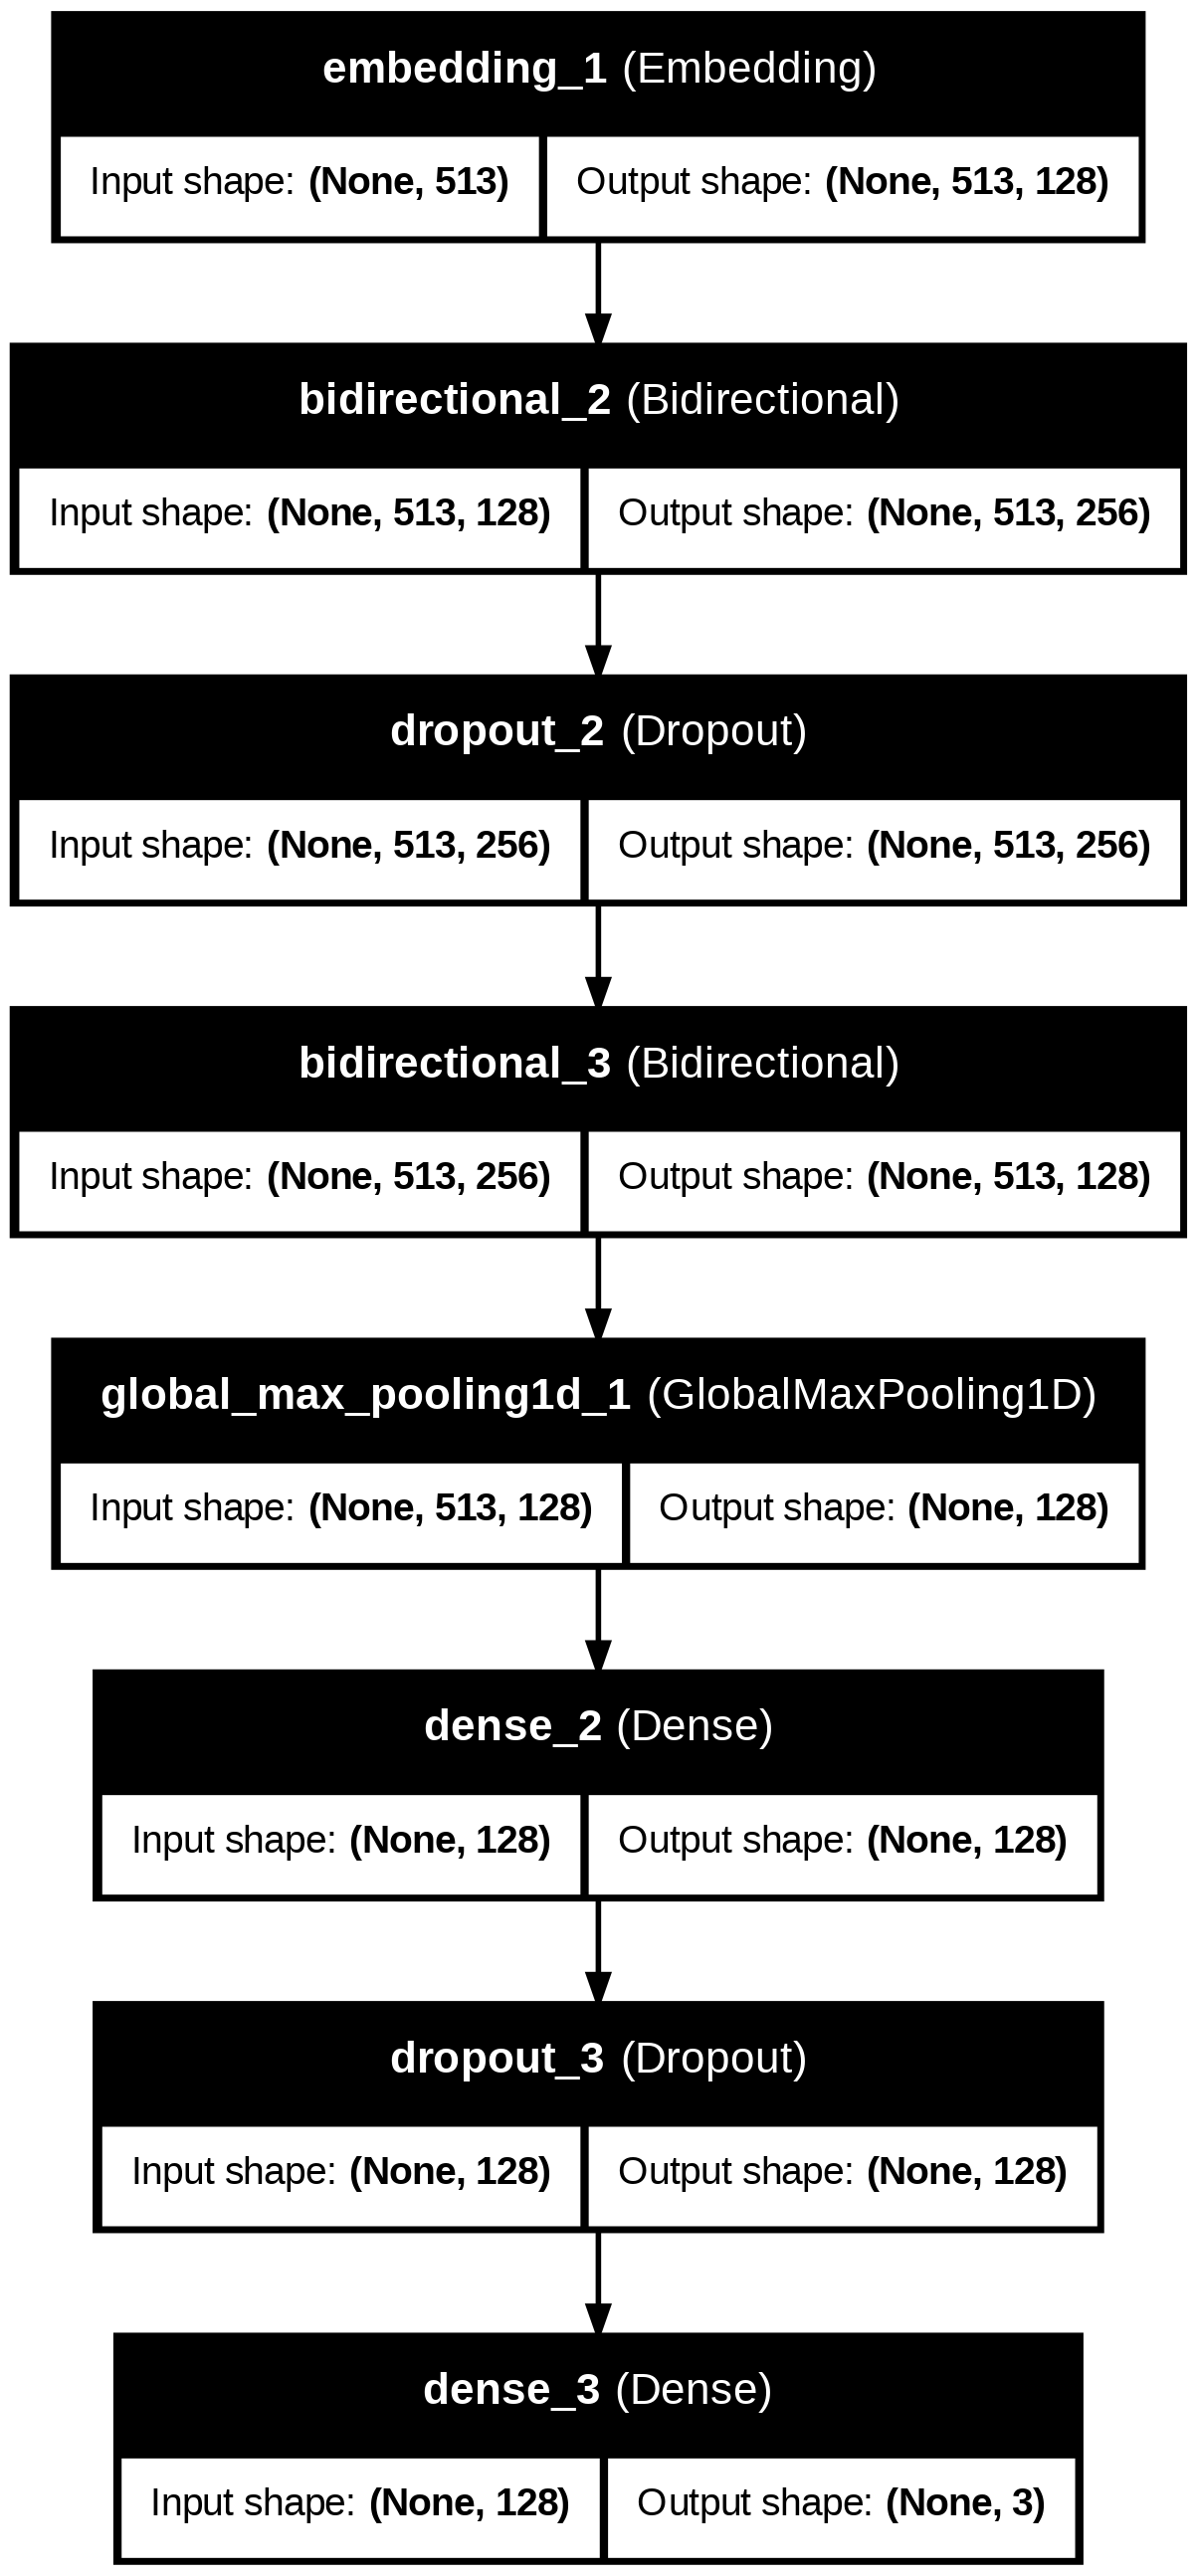

In [76]:
tf.keras.utils.plot_model(model,show_shapes=True, show_layer_names=True)

### Model Evaluation

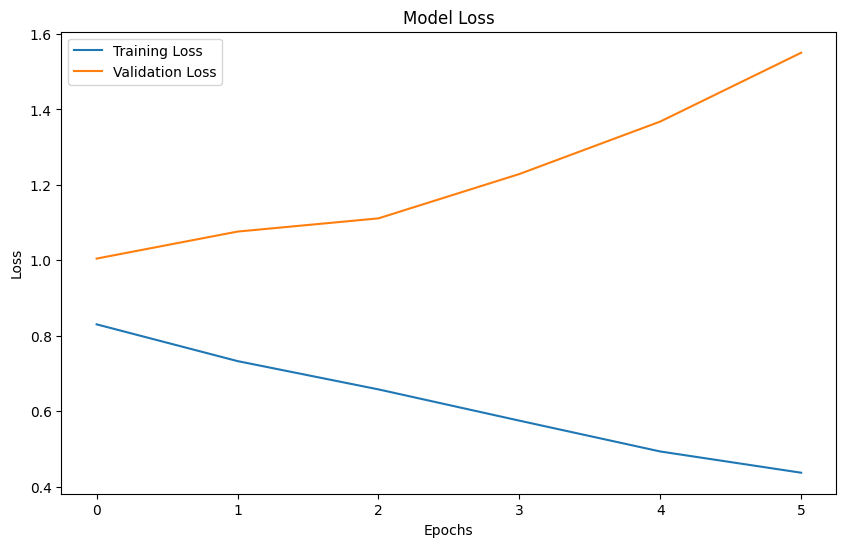

In [77]:
# Loss Plots
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

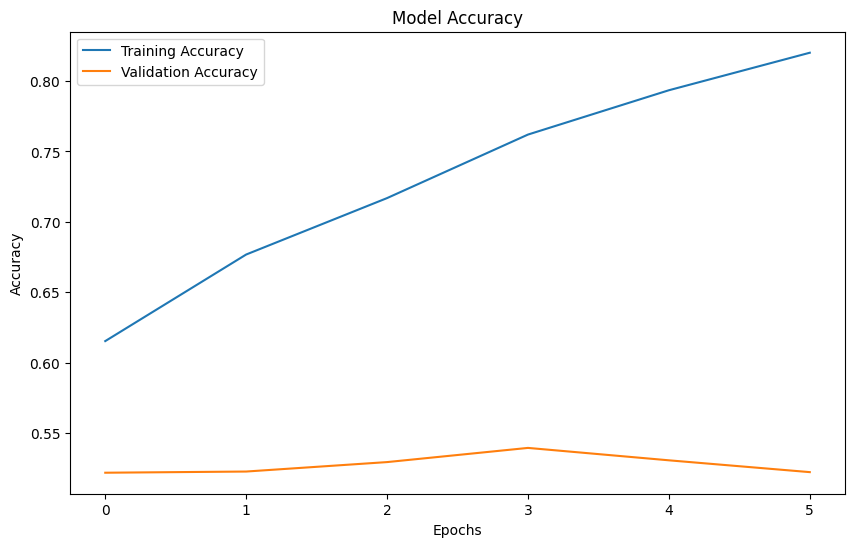

In [78]:
# Accuracy Plots
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

The metrics below represent the priority probabilities of the incoming requests

In [79]:
predictions = model.predict(x_test)

predicted_classes = np.argmax(predictions, axis=1)

# Map predicted classes to priority
class_to_priority = {0: 'high', 1: 'low', 2: 'medium'}
predicted_priority = [class_to_priority[pred] for pred in predicted_classes]

# Displays all class probabilities for each sample
for i, pred in enumerate(predictions):
    print(f"Sample {i + 1}:")
    for class_idx, class_prob in enumerate(pred):
        print(f"  {class_to_priority[class_idx]}: {class_prob:.4f}")

Streaming output truncated to the last 5000 lines.
Sample 1136:
  high: 0.5093
  low: 0.1048
  medium: 0.3860
Sample 1137:
  high: 0.2091
  low: 0.2251
  medium: 0.5659
Sample 1138:
  high: 0.2450
  low: 0.2507
  medium: 0.5044
Sample 1139:
  high: 0.4792
  low: 0.2191
  medium: 0.3018
Sample 1140:
  high: 0.2202
  low: 0.3271
  medium: 0.4526
Sample 1141:
  high: 0.9106
  low: 0.0123
  medium: 0.0772
Sample 1142:
  high: 0.8999
  low: 0.0089
  medium: 0.0912
Sample 1143:
  high: 0.6875
  low: 0.1092
  medium: 0.2034
Sample 1144:
  high: 0.9448
  low: 0.0035
  medium: 0.0514
Sample 1145:
  high: 0.2019
  low: 0.4165
  medium: 0.3816
Sample 1146:
  high: 0.8843
  low: 0.0221
  medium: 0.0937
Sample 1147:
  high: 0.2991
  low: 0.1888
  medium: 0.5122
Sample 1148:
  high: 0.9678
  low: 0.0017
  medium: 0.0306
Sample 1149:
  high: 0.4316
  low: 0.1349
  medium: 0.4333
Sample 1150:
  high: 0.3594
  low: 0.1329
  medium: 0.5078
Sample 1151:
  high: 0.2192
  low: 0.1237
  medium: 0.6572
Sampl